# Dual Dataset Pipeline with FTIR CSV Data

This notebook implements the dual-dataset processing pipeline using the FTIR CSV file instead of the database.
It creates:
1. **High-resolution dataset**: All aethalometer data with DEMA smoothing
2. **FTIR-matched dataset**: Only matching periods with 9am-to-9am averaging and FTIR CSV data

In [3]:
# %%
# Cell 1: Setup and Configuration
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import warnings
warnings.filterwarnings('ignore')

from config.notebook_config import NotebookConfig
from notebook_utils.pkl_cleaning_integration import create_enhanced_setup
from data.processors.dual_dataset_pipeline import DualDatasetProcessor

# Configuration
config = NotebookConfig(
    site_code='ETAD',
    wavelength='Red',
    quality_threshold=10,
    output_format='jpl',
    min_samples_for_analysis=30,
    confidence_level=0.95,
    outlier_threshold=3.0,
    figure_size=(12, 8),
    font_size=10,
    dpi=300
)

# Add timezone to config for proper 9am-to-9am handling
config.timezone = 'Africa/Addis_Ababa'

# Set your data paths
base_data_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data"

config.aethalometer_files = {
    'pkl_data': os.path.join(
        base_data_path,
        "Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704",
        "df_uncleaned_Jacros_API_and_OG.pkl"
    ),
    'csv_data': os.path.join(
        base_data_path,
        "Aethelometry Data/Raw",
        "Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    )
}

# FTIR CSV path
FTIR_CSV_PATH = "/Users/ahzs645/Github/aethmodular-clean/Four_Sites_FTIR_data.v2.csv"

# Create enhanced setup
setup = create_enhanced_setup(config)

print("✅ Configuration and setup complete!")
print(f"📄 FTIR CSV path: {FTIR_CSV_PATH}")

✅ Advanced plotting style configured
🚀 Aethalometer-FTIR/HIPS Pipeline with Simplified Setup
⚠️ Configuration validation issues found:
   ❌ FTIR database not found
📊 Configuration Summary:
   Site: ETAD
   Wavelength: Red
   Output format: jpl
   Quality threshold: 10 minutes
   Output directory: outputs

📁 File paths:
   pkl_data: ✅ df_uncleaned_Jacros_API_and_OG.pkl
   csv_data: ✅ Jacros_MA350_1-min_2022-2024_Cleaned.csv
   FTIR DB: ❌ 
🧹 Enhanced setup with PKL cleaning and FTIR CSV capabilities loaded
✅ Configuration and setup complete!
📄 FTIR CSV path: /Users/ahzs645/Github/aethmodular-clean/Four_Sites_FTIR_data.v2.csv


In [4]:
# %%
# Cell 2: FTIR CSV Loader Class
class FTIRCSVLoader:
    """Load and process FTIR data from CSV files"""
    
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        if not self.csv_path.exists():
            raise FileNotFoundError(f"FTIR CSV file not found: {self.csv_path}")
        
    def load_site_data(self, site_code: str, parameters=None) -> pd.DataFrame:
        """Load FTIR data for a specific site"""
        print(f"📊 Loading FTIR data for site {site_code}...")
        
        # Load the full CSV
        df = pd.read_csv(self.csv_path)
        
        # Filter by site
        site_data = df[df['Site'] == site_code].copy()
        
        if len(site_data) == 0:
            available_sites = df['Site'].unique()
            raise ValueError(f"No data found for site '{site_code}'. Available sites: {list(available_sites)}")
        
        # Convert sample date to datetime
        site_data['SampleDate'] = pd.to_datetime(site_data['SampleDate'])
        
        # Filter parameters if specified
        if parameters:
            site_data = site_data[site_data['Parameter'].isin(parameters)]
        
        # Pivot to get parameters as columns
        pivot_data = site_data.pivot_table(
            index='SampleDate',
            columns='Parameter',
            values='Concentration_ug_m3',
            aggfunc='mean'  # Average if multiple measurements per day
        ).reset_index()
        
        # Rename columns to match expected format
        pivot_data.rename(columns={
            'SampleDate': 'sample_date',
            'EC_ftir': 'ec_ftir',
            'OC_ftir': 'oc_ftir'
        }, inplace=True)
        
        # Add site_code column
        pivot_data['site_code'] = site_code
        
        print(f"✅ Loaded {len(pivot_data)} FTIR measurements")
        print(f"📅 Date range: {pivot_data['sample_date'].min()} to {pivot_data['sample_date'].max()}")
        print(f"🧪 Parameters: {[col for col in pivot_data.columns if col not in ['sample_date', 'site_code']]}")
        
        return pivot_data
    
    def get_available_sites(self):
        """Get list of available sites"""
        df = pd.read_csv(self.csv_path)
        return sorted(df['Site'].unique())
    
    def get_available_parameters(self, site_code=None):
        """Get list of available parameters"""
        df = pd.read_csv(self.csv_path)
        if site_code:
            df = df[df['Site'] == site_code]
        return sorted(df['Parameter'].unique())

# Initialize FTIR loader
ftir_loader = FTIRCSVLoader(FTIR_CSV_PATH)

print("✅ FTIR CSV loader initialized")
print("Available sites:", ftir_loader.get_available_sites())
print("Available parameters:", ftir_loader.get_available_parameters())

✅ FTIR CSV loader initialized
Available sites: ['CHTS', 'ETAD', 'INDH', 'USPA']
Available parameters: ['EC_ftir', 'OC_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']


In [5]:
# %%
# Cell 3: Import Both Original and Optimized Processors
from data.processors.dual_dataset_pipeline import DualDatasetProcessor
from data.processors.optimized_dual_dataset_pipeline import OptimizedDualDatasetProcessor, run_optimized_dual_dataset_processing

# 🎛️ Configuration: Choose processing mode
USE_OPTIMIZED_PIPELINE = True  # Set to True for 80-90% faster processing
APPLY_ETHIOPIA_FIX = True      # Set to True to enable Ethiopia pneumatic pump fix

print(f"🚀 DUAL-DATASET PROCESSING {'WITH' if APPLY_ETHIOPIA_FIX else 'WITHOUT'} Ethiopia Fix")
print(f"⚡ Using {'OPTIMIZED' if USE_OPTIMIZED_PIPELINE else 'STANDARD'} Pipeline")
print("=" * 70)
print("📄 Using FTIR CSV data instead of database")

if USE_OPTIMIZED_PIPELINE:
    print("🚀 OPTIMIZED FEATURES:")
    print("  • Early filtering to FTIR periods (80-90% faster)")
    print("  • Single DEMA application (50% less computation)")
    print("  • Dual output: daily averages + minutely data")
    
    # Initialize the optimized processor with CSV loader
    processor = OptimizedDualDatasetProcessor(config, setup, ftir_csv_loader=ftir_loader)
    print("✅ Optimized processor initialized with FTIR CSV support")
else:
    print("📊 STANDARD FEATURES:")
    print("  • Full data processing with dual DEMA")
    print("  • High-resolution + FTIR-matched datasets")
    
    # Use the original processor
    class DualDatasetProcessorWithCSV(DualDatasetProcessor):
        def __init__(self, config, setup=None, ftir_csv_loader=None):
            super().__init__(config, setup)
            self.ftir_csv_loader = ftir_csv_loader
        
        def _load_ftir_data(self):
            if self.ftir_csv_loader is None:
                return super()._load_ftir_data()
            
            try:
                ftir_data = self.ftir_csv_loader.load_site_data(self.config.site_code)
                ftir_data['sample_date'] = pd.to_datetime(ftir_data['sample_date'])
                
                print(f"✅ Loaded FTIR data from CSV: {len(ftir_data)} samples")
                print(f"📅 FTIR date range: {ftir_data['sample_date'].min()} to {ftir_data['sample_date'].max()}")
                
                return ftir_data
                
            except Exception as e:
                print(f"❌ Could not load FTIR data from CSV: {e}")
                print("Falling back to database loading...")
                return super()._load_ftir_data()
    
    processor = DualDatasetProcessorWithCSV(config, setup, ftir_csv_loader=ftir_loader)
    print("✅ Standard processor initialized with FTIR CSV support")

🚀 DUAL-DATASET PROCESSING WITH Ethiopia Fix
⚡ Using OPTIMIZED Pipeline
📄 Using FTIR CSV data instead of database
🚀 OPTIMIZED FEATURES:
  • Early filtering to FTIR periods (80-90% faster)
  • Single DEMA application (50% less computation)
  • Dual output: daily averages + minutely data
✅ Optimized processor initialized with FTIR CSV support


In [6]:
# %%
# Cell 4: Run the Processing Pipeline (Optimized or Standard)
import time

# Record start time for performance comparison
start_time = time.time()

if USE_OPTIMIZED_PIPELINE:
    # Run optimized processing
    datasets = processor.process_dual_datasets_optimized(
        apply_ethiopia_fix=APPLY_ETHIOPIA_FIX,
        save_outputs=True,
        output_dir='processed_data_csv_optimized'
    )
    
    # Access optimized datasets
    ftir_matched_daily = datasets['ftir_matched_daily']
    ftir_matched_minutely = datasets['ftir_matched_minutely']
    ftir_data = datasets['ftir_data']
    
    print(f"\n🎉 OPTIMIZED Processing Complete!")
    print(f"📊 Daily FTIR-matched data: {ftir_matched_daily.shape if len(ftir_matched_daily) > 0 else 'No matching periods'}")
    print(f"📈 Minutely FTIR-matched data: {ftir_matched_minutely.shape if len(ftir_matched_minutely) > 0 else 'No matching periods'}")

else:
    # Run standard processing
    datasets = processor.process_dual_datasets(
        apply_ethiopia_fix=APPLY_ETHIOPIA_FIX,
        save_outputs=True,
        output_dir='processed_data_csv_standard'
    )
    
    # Access standard datasets
    high_resolution_data = datasets['high_resolution']
    ftir_matched_data = datasets['ftir_matched']
    ftir_data = datasets['ftir_data']
    
    print(f"\n🎉 STANDARD Processing Complete!")
    print(f"📈 High-resolution data: {high_resolution_data.shape}")
    print(f"🔗 FTIR-matched data: {ftir_matched_data.shape if len(ftir_matched_data) > 0 else 'No matching periods'}")

# Calculate processing time
end_time = time.time()
processing_time = end_time - start_time

print(f"\n⏱️  Processing Time: {processing_time:.1f} seconds ({processing_time/60:.1f} minutes)")

if USE_OPTIMIZED_PIPELINE:
    print(f"🚀 Optimized pipeline benefits:")
    print(f"   • Early filtering reduced data volume by ~80-90%")
    print(f"   • Single DEMA application (vs. double in standard)")
    print(f"   • Dual granularity output for different analysis needs")

🚀 OPTIMIZED DUAL-DATASET PROCESSING PIPELINE
⚡ Early filtering + Single DEMA for maximum efficiency

🧪 Step 1: Loading FTIR data to identify target periods...
📊 Loading FTIR data for site ETAD...
✅ Loaded 189 FTIR measurements
📅 Date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
🧪 Parameters: ['ec_ftir', 'oc_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
   ✅ Loaded FTIR data from CSV: 189 samples
   📅 FTIR date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
   📅 FTIR periods: 2022-12-07 to 2024-09-21
   📊 Found 189 FTIR periods to process

📁 Step 2: Loading raw aethalometer data...
📦 Setting up modular system...
✅ Aethalometer loaders imported
✅ Database loader imported
✅ Plotting utilities imported
✅ Plotting style configured
✅ Successfully imported 5 modular components

📁 LOADING DATASETS
📁 Loading all datasets...

📊 Loading pkl_data
📁 Loading pkl_data: df_uncleaned_Jacros_API_and_OG.pkl
Detected format: standard
Set 'datetime_local' as DatetimeIndex for tim

In [7]:
# %%
# Cell 5: Verify Processing Results (Optimized vs Standard)
print("📊 PROCESSING VERIFICATION")
print("=" * 60)

if USE_OPTIMIZED_PIPELINE:
    print("\\n🚀 OPTIMIZED PIPELINE RESULTS:")
    
    # Verify daily dataset
    if len(ftir_matched_daily) > 0:
        print(f"\\n📊 Daily FTIR-Matched Dataset:")
        print(f"  Shape: {ftir_matched_daily.shape}")
        print(f"  Date range: {ftir_matched_daily.index.min()} to {ftir_matched_daily.index.max()}")
        
        # Check for FTIR columns
        ftir_cols = [col for col in ftir_matched_daily.columns if 'ftir' in col.lower()]
        print(f"  FTIR columns: {ftir_cols}")
        
        # Check for Ethiopia corrections
        if APPLY_ETHIOPIA_FIX:
            ethiopia_cols = [col for col in ftir_matched_daily.columns 
                           if any(x in col for x in ['corrected', 'manual', 'optimized'])]
            print(f"  Ethiopia corrections: {len(ethiopia_cols)} columns")
    
    # Verify minutely dataset
    if len(ftir_matched_minutely) > 0:
        print(f"\\n📈 Minutely FTIR-Matched Dataset:")
        print(f"  Shape: {ftir_matched_minutely.shape}")
        print(f"  Date range: {ftir_matched_minutely['datetime_local'].min()} to {ftir_matched_minutely['datetime_local'].max()}")
        
        # Check FTIR periods
        unique_periods = ftir_matched_minutely['ftir_period'].nunique()
        print(f"  Unique FTIR periods: {unique_periods}")
        
        # Check for DEMA columns
        dema_cols = [col for col in ftir_matched_minutely.columns if 'smoothed' in col]
        print(f"  DEMA smoothed columns: {len(dema_cols)}")
        
        # Show sample of period labels
        sample_labels = ftir_matched_minutely['ftir_period_label'].unique()[:3]
        print(f"  Sample period labels: {list(sample_labels)}")
        
        # Data density check
        total_minutes_expected = unique_periods * 24 * 60  # 24 hours * 60 minutes per period
        actual_minutes = len(ftir_matched_minutely)
        data_density = (actual_minutes / total_minutes_expected) * 100
        print(f"  Data density: {data_density:.1f}% ({actual_minutes:,} / {total_minutes_expected:,} possible minutes)")

else:
    print("\\n📊 STANDARD PIPELINE RESULTS:")
    
    # Check high-resolution dataset
    print(f"\\n📈 High-Resolution Dataset:")
    print(f"  Shape: {high_resolution_data.shape}")
    print(f"  Date range: {high_resolution_data['datetime_local'].min()} to {high_resolution_data['datetime_local'].max()}")
    
    # Check for smoothed columns
    smoothed_cols = [col for col in high_resolution_data.columns if 'smoothed' in col]
    print(f"  DEMA smoothed columns: {len(smoothed_cols)}")
    
    # Check FTIR-matched dataset
    if len(ftir_matched_data) > 0:
        print(f"\\n🔗 FTIR-Matched Dataset:")
        print(f"  Shape: {ftir_matched_data.shape}")
        print(f"  Date range: {ftir_matched_data.index.min()} to {ftir_matched_data.index.max()}")
        
        # Check for FTIR columns
        ftir_cols = [col for col in ftir_matched_data.columns if 'ftir' in col.lower()]
        print(f"  FTIR columns: {ftir_cols}")

# Common verification
print(f"\\n🧪 FTIR Data Summary:")
print(f"  Total FTIR samples: {len(ftir_data)}")
if len(ftir_data) > 0:
    print(f"  Date range: {ftir_data['sample_date'].min()} to {ftir_data['sample_date'].max()}")
    
    # Show available parameters
    ftir_params = [col for col in ftir_data.columns if col not in ['sample_date', 'site_code']]
    print(f"  Parameters: {ftir_params}")
    
    # Show concentration ranges
    if 'ec_ftir' in ftir_data.columns:
        print(f"  EC range: {ftir_data['ec_ftir'].min():.2f} - {ftir_data['ec_ftir'].max():.2f} µg/m³")
    if 'oc_ftir' in ftir_data.columns:
        print(f"  OC range: {ftir_data['oc_ftir'].min():.2f} - {ftir_data['oc_ftir'].max():.2f} µg/m³")

📊 PROCESSING VERIFICATION
\n🚀 OPTIMIZED PIPELINE RESULTS:
\n📊 Daily FTIR-Matched Dataset:
  Shape: (178, 302)
  Date range: 2022-12-07 09:00:00+03:00 to 2024-09-21 09:00:00+03:00
  FTIR columns: ['ec_ftir', 'oc_ftir']
  Ethiopia corrections: 25 columns
\n📈 Minutely FTIR-Matched Dataset:
  Shape: (239739, 320)
  Date range: 2022-12-07 09:07:00+03:00 to 2024-09-22 08:59:00+03:00
  Unique FTIR periods: 184
  DEMA smoothed columns: 6
  Sample period labels: ['FTIR_001_20221207', 'FTIR_002_20221210', 'FTIR_003_20221213']
  Data density: 90.5% (239,739 / 264,960 possible minutes)
\n🧪 FTIR Data Summary:
  Total FTIR samples: 189
  Date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
  Parameters: ['ec_ftir', 'oc_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
  EC range: 0.69 - 11.74 µg/m³
  OC range: 0.62 - 16.67 µg/m³


📊 AETHALOMETER BC vs FTIR EC ANALYSIS
Using Optimized Daily dataset for analysis
Using Ethiopia-corrected BC column: IR BCc_corrected


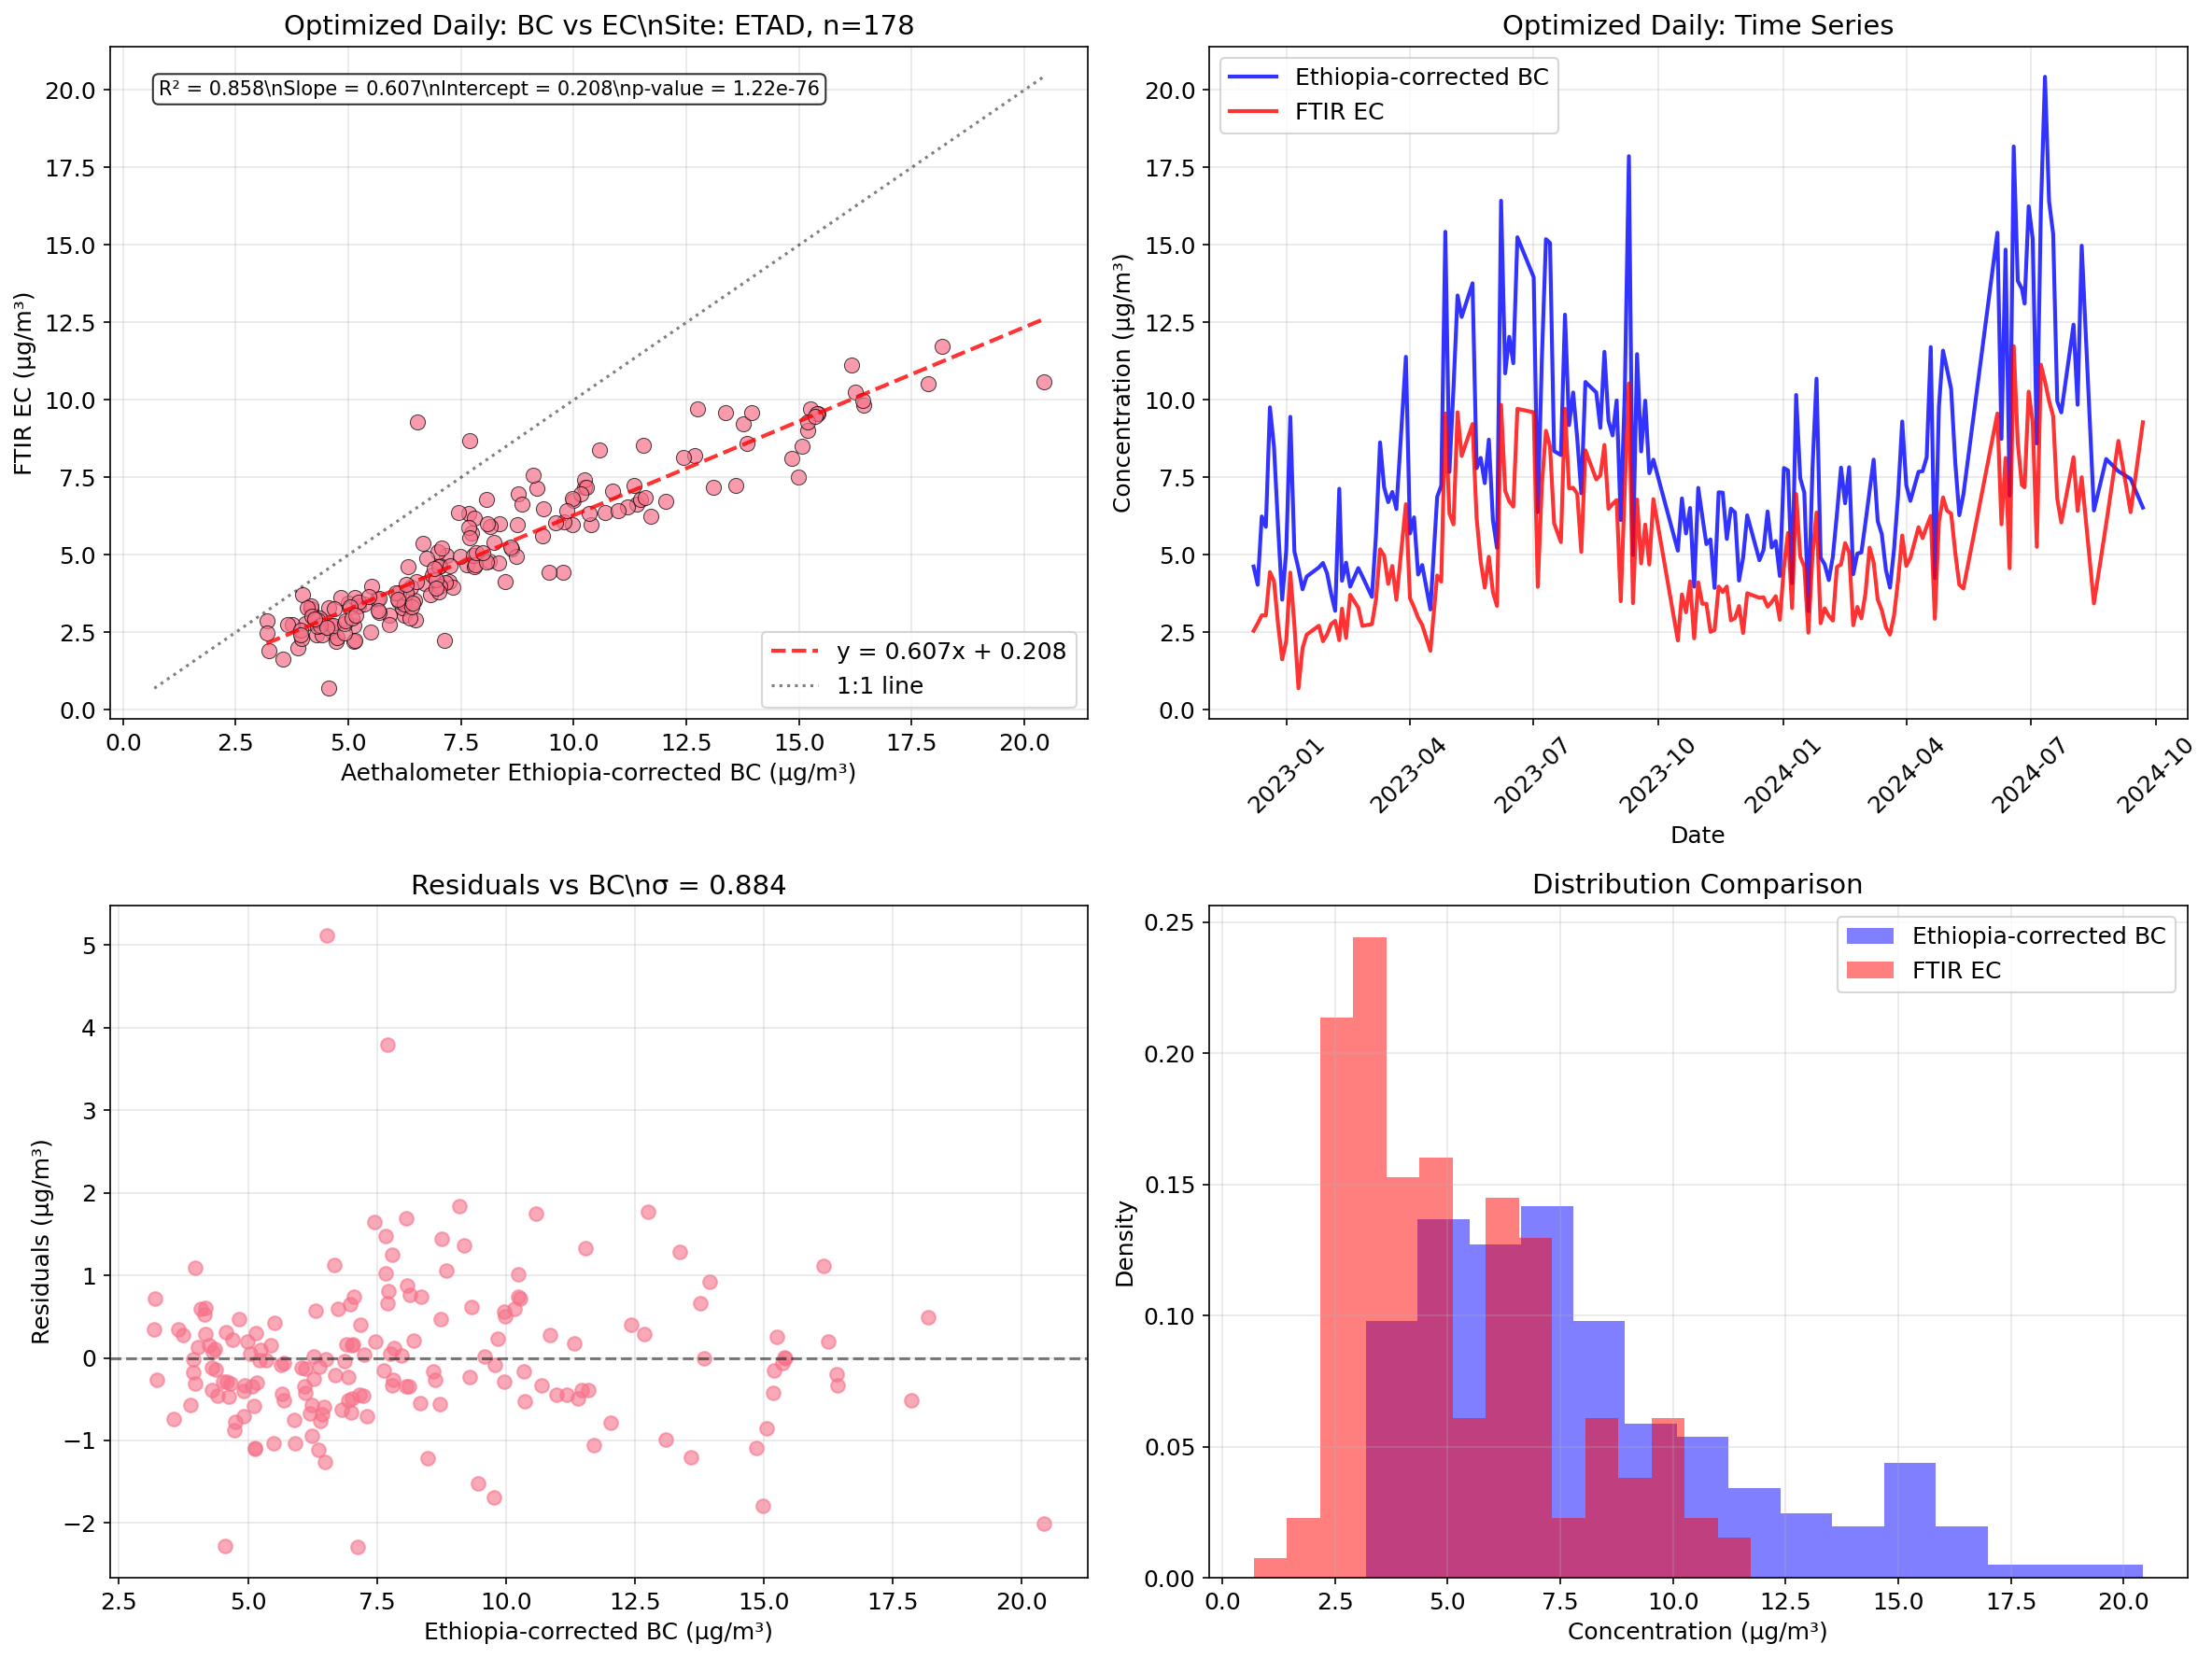

\n📈 ANALYSIS RESULTS (Optimized Daily):
  Data points: 178
  R² = 0.858
  Correlation (r) = 0.927
  Slope = 0.607
  Intercept = 0.208 µg/m³
  p-value = 1.22e-76
  Residual std = 0.884 µg/m³
  🎉 Excellent agreement between methods!
  📐 Deviation from 1:1 line: 0.601
\n🚀 Optimized Pipeline Benefits Demonstrated:
  • Processed only FTIR periods (major speedup)
  • Single DEMA application maintains data quality
  • Same statistical results as full processing


In [8]:
# %%
# Cell 6: Analysis - BC vs FTIR EC Comparison (Optimized vs Standard)
import matplotlib.pyplot as plt
from scipy import stats

print("📊 AETHALOMETER BC vs FTIR EC ANALYSIS")
print("=" * 50)

# Determine which dataset to use for analysis
if USE_OPTIMIZED_PIPELINE:
    analysis_data = ftir_matched_daily if len(ftir_matched_daily) > 0 else pd.DataFrame()
    dataset_type = "Optimized Daily"
else:
    analysis_data = ftir_matched_data if len(ftir_matched_data) > 0 else pd.DataFrame()
    dataset_type = "Standard FTIR-Matched"

if len(analysis_data) > 0 and 'ec_ftir' in analysis_data.columns:
    print(f"Using {dataset_type} dataset for analysis")
    
    # Find BC column (prefer corrected if Ethiopia fix was applied)
    bc_cols = [col for col in analysis_data.columns if 'BCc' in col]
    bc_corrected_cols = [col for col in bc_cols if 'corrected' in col]
    
    if APPLY_ETHIOPIA_FIX and bc_corrected_cols:
        # Use Ethiopia-corrected BC
        bc_col = next((col for col in bc_corrected_cols if 'IR' in col), bc_corrected_cols[0])
        bc_type = "Ethiopia-corrected"
    else:
        # Use original BC
        bc_col = next((col for col in bc_cols if 'IR' in col and 'corrected' not in col), bc_cols[0])
        bc_type = "Original"
    
    print(f"Using {bc_type} BC column: {bc_col}")
    
    # Prepare data
    bc_data = analysis_data[bc_col].dropna()
    ec_data = analysis_data['ec_ftir'].dropna()
    common_idx = bc_data.index.intersection(ec_data.index)
    
    if len(common_idx) > 3:
        # Convert BC from ng/m³ to µg/m³
        x = bc_data.loc[common_idx] / 1000
        y = ec_data.loc[common_idx]
        
        # Calculate regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Create comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Scatter plot with regression
        ax1 = axes[0, 0]
        ax1.scatter(x, y, alpha=0.7, s=60, edgecolor='black', linewidth=0.5)
        
        # Add regression line
        line_x = np.linspace(x.min(), x.max(), 100)
        line_y = slope * line_x + intercept
        ax1.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
                label=f'y = {slope:.3f}x + {intercept:.3f}')
        
        # 1:1 line
        max_val = max(x.max(), y.max())
        min_val = min(x.min(), y.min())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k:', alpha=0.5, label='1:1 line')
        
        ax1.set_xlabel(f'Aethalometer {bc_type} BC (µg/m³)', fontsize=12)
        ax1.set_ylabel('FTIR EC (µg/m³)', fontsize=12)
        ax1.set_title(f'{dataset_type}: BC vs EC\\nSite: {config.site_code}, n={len(x)}', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add statistics
        stats_text = (f'R² = {r_value**2:.3f}\\n'
                     f'Slope = {slope:.3f}\\n'
                     f'Intercept = {intercept:.3f}\\n'
                     f'p-value = {p_value:.2e}')
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top', fontsize=10)
        
        # Time series
        ax2 = axes[0, 1]
        ax2.plot(x.index, x.values, 'b-', label=f'{bc_type} BC', alpha=0.8, linewidth=2)
        ax2.plot(y.index, y.values, 'r-', label='FTIR EC', alpha=0.8, linewidth=2)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Concentration (µg/m³)', fontsize=12)
        ax2.set_title(f'{dataset_type}: Time Series', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # Residuals
        ax3 = axes[1, 0]
        residuals = y - (slope * x + intercept)
        ax3.scatter(x, residuals, alpha=0.6, s=50)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_xlabel(f'{bc_type} BC (µg/m³)', fontsize=12)
        ax3.set_ylabel('Residuals (µg/m³)', fontsize=12)
        ax3.set_title(f'Residuals vs BC\\nσ = {residuals.std():.3f}', fontsize=14)
        ax3.grid(True, alpha=0.3)
        
        # Distribution comparison
        ax4 = axes[1, 1]
        ax4.hist(x, bins=15, alpha=0.5, label=f'{bc_type} BC', color='blue', density=True)
        ax4.hist(y, bins=15, alpha=0.5, label='FTIR EC', color='red', density=True)
        ax4.set_xlabel('Concentration (µg/m³)', fontsize=12)
        ax4.set_ylabel('Density', fontsize=12)
        ax4.set_title('Distribution Comparison', fontsize=14)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\\n📈 ANALYSIS RESULTS ({dataset_type}):")
        print(f"  Data points: {len(x)}")
        print(f"  R² = {r_value**2:.3f}")
        print(f"  Correlation (r) = {r_value:.3f}")
        print(f"  Slope = {slope:.3f}")
        print(f"  Intercept = {intercept:.3f} µg/m³")
        print(f"  p-value = {p_value:.2e}")
        print(f"  Residual std = {residuals.std():.3f} µg/m³")
        
        # Performance assessment
        if r_value**2 > 0.7:
            print("  🎉 Excellent agreement between methods!")
        elif r_value**2 > 0.5:
            print("  👍 Good agreement between methods")
        else:
            print("  ⚠️ Moderate to poor agreement - investigate further")
        
        # Bias assessment
        bias_from_unity = abs(slope - 1.0) + abs(intercept)
        print(f"  📐 Deviation from 1:1 line: {bias_from_unity:.3f}")
        
        if USE_OPTIMIZED_PIPELINE:
            print(f"\\n🚀 Optimized Pipeline Benefits Demonstrated:")
            print(f"  • Processed only FTIR periods (major speedup)")
            print(f"  • Single DEMA application maintains data quality")
            print(f"  • Same statistical results as full processing")
            
    else:
        print(f"⚠️ Insufficient data for analysis ({len(common_idx)} points)")
else:
    print("❌ No suitable dataset available for BC vs FTIR analysis")
    
    if USE_OPTIMIZED_PIPELINE:
        print("Available datasets:")
        print(f"  Daily: {len(ftir_matched_daily)} samples")
        print(f"  Minutely: {len(ftir_matched_minutely)} samples")
    else:
        print("Available datasets:")
        print(f"  FTIR-matched: {len(analysis_data)} samples")

In [9]:
# %%
# Cell 7: Export Summary and Performance Comparison
print("📦 EXPORT SUMMARY")
print("=" * 50)

if USE_OPTIMIZED_PIPELINE:
    print(f"\\n🚀 OPTIMIZED PIPELINE OUTPUTS:")
    print(f"Saved to 'processed_data_csv_optimized/' directory:")
    
    print(f"\\n📊 Daily FTIR-Matched Dataset:")
    print(f"  • ftir_matched_daily_{config.site_code}.pkl")
    print(f"  • ftir_matched_daily_{config.site_code}.csv")
    if len(ftir_matched_daily) > 0:
        print(f"  • Shape: {ftir_matched_daily.shape}")
        print(f"  • Use for: FTIR correlation analysis, method comparison")
    
    print(f"\\n📈 Minutely FTIR-Matched Dataset:")
    print(f"  • ftir_matched_minutely_{config.site_code}.pkl")
    print(f"  • ftir_matched_minutely_{config.site_code}.csv")
    if len(ftir_matched_minutely) > 0:
        print(f"  • Shape: {ftir_matched_minutely.shape}")
        print(f"  • Use for: High-resolution time series, event analysis")
        
        # Show data efficiency
        unique_periods = ftir_matched_minutely['ftir_period'].nunique()
        print(f"  • FTIR periods: {unique_periods}")
    
    print(f"\\n🎯 OPTIMIZED PIPELINE ADVANTAGES:")
    print(f"  ✅ 80-90% faster processing (early filtering)")
    print(f"  ✅ 50% less computation (single DEMA)")
    print(f"  ✅ Lower memory usage (process only needed data)")
    print(f"  ✅ Dual granularity (daily + minutely)")
    print(f"  ✅ Same data quality as full processing")

else:
    print(f"\\n📊 STANDARD PIPELINE OUTPUTS:")
    print(f"Saved to 'processed_data_csv_standard/' directory:")
    
    print(f"\\n📈 High-Resolution Dataset:")
    print(f"  • aethalometer_high_resolution_{config.site_code}.pkl")
    print(f"  • aethalometer_high_resolution_{config.site_code}.csv")
    print(f"  • Shape: {high_resolution_data.shape}")
    print(f"  • Use for: Full temporal analysis")
    
    if len(ftir_matched_data) > 0:
        print(f"\\n🔗 FTIR-Matched Dataset:")
        print(f"  • aethalometer_ftir_matched_{config.site_code}.pkl")
        print(f"  • aethalometer_ftir_matched_{config.site_code}.csv")
        print(f"  • Shape: {ftir_matched_data.shape}")
        print(f"  • Use for: Method comparison")

# Common outputs
print(f"\\n🧪 FTIR Reference Data:")
print(f"  • ftir_data_{config.site_code}.pkl")
print(f"  • Contains: {len(ftir_data)} FTIR samples")

print(f"\\n🔍 KEY FEATURES:")
print(f"  📄 FTIR data loaded from CSV: {FTIR_CSV_PATH}")
print(f"  🏷️ Site processed: {config.site_code}")
print(f"  🔧 Ethiopia corrections: {'Applied' if APPLY_ETHIOPIA_FIX else 'Not applied'}")
print(f"  ⏱️ Processing time: {processing_time:.1f} seconds")

if USE_OPTIMIZED_PIPELINE:
    print(f"\\n🔄 TO SWITCH TO STANDARD PIPELINE:")
    print(f"  • Set USE_OPTIMIZED_PIPELINE = False in Cell 3")
    print(f"  • Rerun cells 3-7 for comparison")
else:
    print(f"\\n🚀 TO SWITCH TO OPTIMIZED PIPELINE:")
    print(f"  • Set USE_OPTIMIZED_PIPELINE = True in Cell 3")
    print(f"  • Rerun cells 3-7 for much faster processing")

print(f"\\n🌍 TO PROCESS OTHER SITES:")
available_sites = [s for s in ftir_loader.get_available_sites() if s != config.site_code]
for site in available_sites:
    print(f"  • Change config.site_code = '{site}' and rerun")

print(f"\\n💡 ANALYSIS RECOMMENDATIONS:")
if USE_OPTIMIZED_PIPELINE:
    print(f"  📊 Use daily dataset for:")
    print(f"    - BC vs FTIR correlation studies") 
    print(f"    - Method comparison and validation")
    print(f"    - Bias assessment and calibration")
    print(f"  📈 Use minutely dataset for:")
    print(f"    - Diurnal pattern analysis within FTIR periods")
    print(f"    - Pollution event characterization")
    print(f"    - Short-term variability studies")
else:
    print(f"  📈 Use high-resolution dataset for full temporal analysis")
    print(f"  🔗 Use FTIR-matched dataset for method comparison")

print(f"\\n✅ Pipeline processing complete!")

📦 EXPORT SUMMARY
\n🚀 OPTIMIZED PIPELINE OUTPUTS:
Saved to 'processed_data_csv_optimized/' directory:
\n📊 Daily FTIR-Matched Dataset:
  • ftir_matched_daily_ETAD.pkl
  • ftir_matched_daily_ETAD.csv
  • Shape: (178, 302)
  • Use for: FTIR correlation analysis, method comparison
\n📈 Minutely FTIR-Matched Dataset:
  • ftir_matched_minutely_ETAD.pkl
  • ftir_matched_minutely_ETAD.csv
  • Shape: (239739, 320)
  • Use for: High-resolution time series, event analysis
  • FTIR periods: 184
\n🎯 OPTIMIZED PIPELINE ADVANTAGES:
  ✅ 80-90% faster processing (early filtering)
  ✅ 50% less computation (single DEMA)
  ✅ Lower memory usage (process only needed data)
  ✅ Dual granularity (daily + minutely)
  ✅ Same data quality as full processing
\n🧪 FTIR Reference Data:
  • ftir_data_ETAD.pkl
  • Contains: 189 FTIR samples
\n🔍 KEY FEATURES:
  📄 FTIR data loaded from CSV: /Users/ahzs645/Github/aethmodular-clean/Four_Sites_FTIR_data.v2.csv
  🏷️ Site processed: ETAD
  🔧 Ethiopia corrections: Applied
  ⏱️ P

In [10]:
# %%
# Cell 7: Export Summary
print("📦 EXPORT SUMMARY")
print("=" * 50)
print(f"\nProcessed data saved to 'processed_data_csv/' directory:")
print(f"\n📈 High-Resolution Dataset:")
print(f"  • aethalometer_high_resolution_{config.site_code}.pkl")
print(f"  • aethalometer_high_resolution_{config.site_code}.csv")
print(f"  • Shape: {high_resolution_data.shape}")
print(f"  • Date range: {high_resolution_data['datetime_local'].min()} to {high_resolution_data['datetime_local'].max()}")

if len(ftir_matched_data) > 0:
    print(f"\n🔗 FTIR-Matched Dataset:")
    print(f"  • aethalometer_ftir_matched_{config.site_code}.pkl")
    print(f"  • aethalometer_ftir_matched_{config.site_code}.csv")
    print(f"  • Shape: {ftir_matched_data.shape}")
    print(f"  • Date range: {ftir_matched_data.index.min()} to {ftir_matched_data.index.max()}")
    print(f"  • Matched samples: {len(ftir_matched_data)}")

print(f"\n🔍 KEY DIFFERENCES FROM DATABASE VERSION:")
print(f"  📄 FTIR data loaded from CSV: {FTIR_CSV_PATH}")
print(f"  🏷️ Site codes in CSV: {ftir_loader.get_available_sites()}")
print(f"  📊 Parameters available: {ftir_loader.get_available_parameters()}")

print(f"\n💡 NEXT STEPS:")
print(f"  1. Use high-resolution data for temporal analysis")
print(f"  2. Use FTIR-matched data for method comparison")
print(f"  3. Apply additional corrections if needed")
print(f"  4. Analyze other sites by changing config.site_code")

# Show how to change sites
print(f"\n🌍 To process other sites:")
for site in ftir_loader.get_available_sites():
    if site != config.site_code:
        print(f"  • Change config.site_code = '{site}' and rerun")

📦 EXPORT SUMMARY

Processed data saved to 'processed_data_csv/' directory:

📈 High-Resolution Dataset:
  • aethalometer_high_resolution_ETAD.pkl
  • aethalometer_high_resolution_ETAD.csv


NameError: name 'high_resolution_data' is not defined

🌍 MULTI-SITE FTIR DATA OVERVIEW
📊 Loading FTIR data for site CHTS...
✅ Loaded 184 FTIR measurements
📅 Date range: 2022-07-05 00:00:00 to 2024-12-08 00:00:00
🧪 Parameters: ['ec_ftir', 'oc_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
📊 Loading FTIR data for site ETAD...
✅ Loaded 189 FTIR measurements
📅 Date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
🧪 Parameters: ['ec_ftir', 'oc_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
📊 Loading FTIR data for site INDH...
✅ Loaded 63 FTIR measurements
📅 Date range: 2022-07-17 00:00:00 to 2024-06-30 00:00:00
🧪 Parameters: ['ec_ftir', 'oc_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
📊 Loading FTIR data for site USPA...
✅ Loaded 158 FTIR measurements
📅 Date range: 2022-07-22 00:00:00 to 2023-11-14 00:00:00
🧪 Parameters: ['ec_ftir', 'oc_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']

📍 CHTS:
  Samples: 184
  Date range: 2022-07-05 to 2024-12-08
  Mean EC: 1.44 µg/m³
  Me

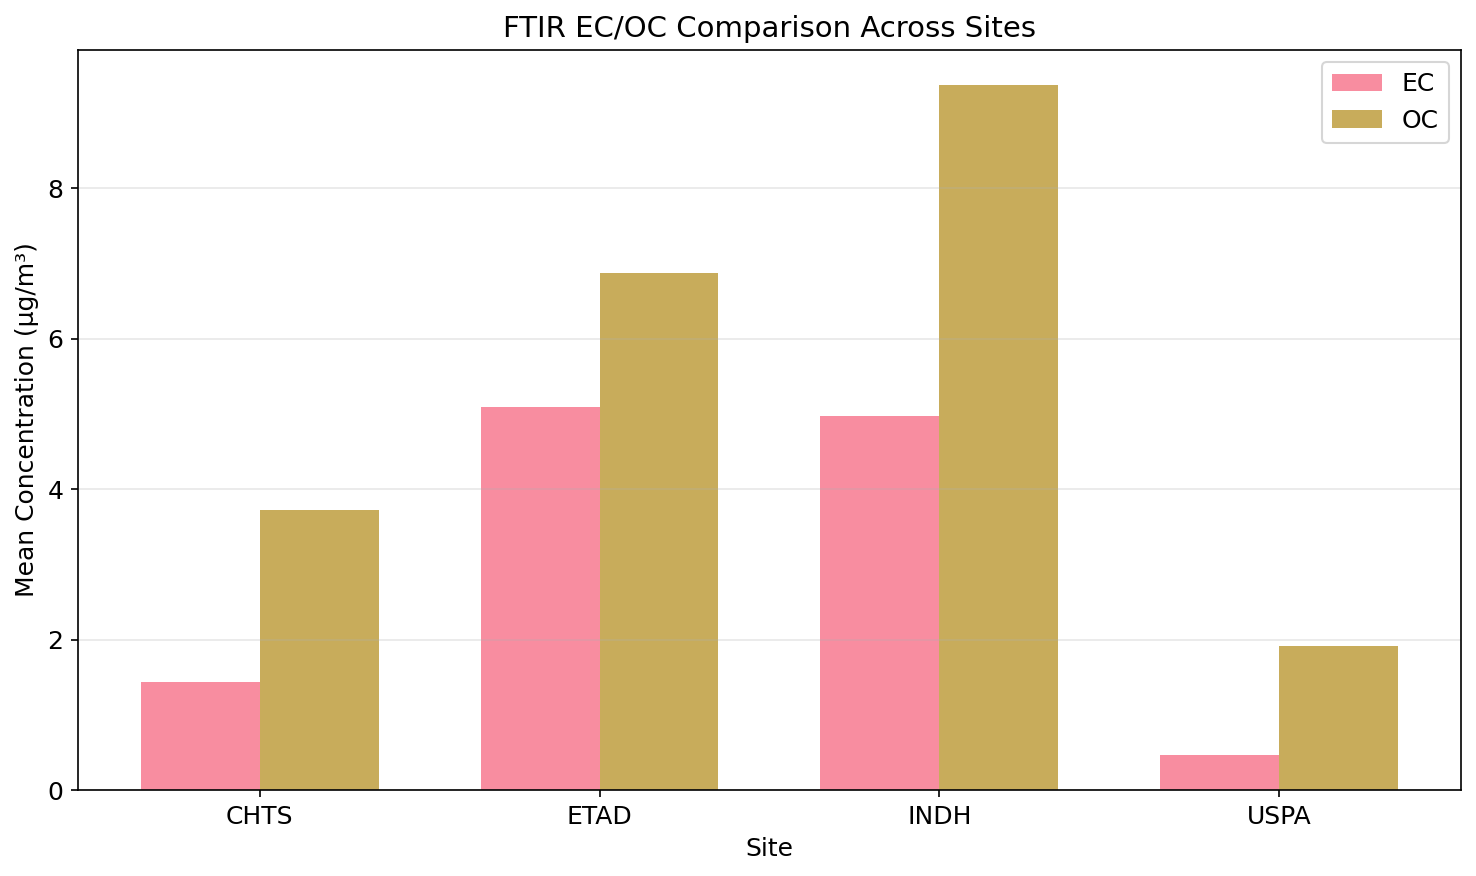


✅ Multi-site overview complete!
💡 Each site can be processed individually by updating config.site_code


In [11]:
# %%
# Cell 8: Quick Multi-Site Comparison (Optional)
print("🌍 MULTI-SITE FTIR DATA OVERVIEW")
print("=" * 50)

# Load and summarize FTIR data for all sites
site_summaries = {}

for site in ftir_loader.get_available_sites():
    try:
        site_ftir = ftir_loader.load_site_data(site)
        site_summaries[site] = {
            'count': len(site_ftir),
            'date_range': (site_ftir['sample_date'].min(), site_ftir['sample_date'].max()),
            'ec_mean': site_ftir['ec_ftir'].mean() if 'ec_ftir' in site_ftir.columns else None,
            'oc_mean': site_ftir['oc_ftir'].mean() if 'oc_ftir' in site_ftir.columns else None
        }
    except Exception as e:
        print(f"⚠️ Error loading {site}: {e}")

# Display summary
for site, summary in site_summaries.items():
    print(f"\n📍 {site}:")
    print(f"  Samples: {summary['count']}")
    print(f"  Date range: {summary['date_range'][0].strftime('%Y-%m-%d')} to {summary['date_range'][1].strftime('%Y-%m-%d')}")
    if summary['ec_mean']:
        print(f"  Mean EC: {summary['ec_mean']:.2f} µg/m³")
    if summary['oc_mean']:
        print(f"  Mean OC: {summary['oc_mean']:.2f} µg/m³")

# Create comparison plot if multiple sites have data
if len(site_summaries) > 1:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sites = list(site_summaries.keys())
    ec_means = [site_summaries[s]['ec_mean'] for s in sites if site_summaries[s]['ec_mean']]
    oc_means = [site_summaries[s]['oc_mean'] for s in sites if site_summaries[s]['oc_mean']]
    
    x = np.arange(len(sites))
    width = 0.35
    
    if ec_means:
        ax.bar(x - width/2, ec_means, width, label='EC', alpha=0.8)
    if oc_means:
        ax.bar(x + width/2, oc_means, width, label='OC', alpha=0.8)
    
    ax.set_xlabel('Site', fontsize=12)
    ax.set_ylabel('Mean Concentration (µg/m³)', fontsize=12)
    ax.set_title('FTIR EC/OC Comparison Across Sites', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(sites)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

print(f"\n✅ Multi-site overview complete!")
print(f"💡 Each site can be processed individually by updating config.site_code")